In [1]:
# Import necessary libraries
import jax.numpy as jnp
from jax import random, grad, jit, lax, jacrev
from jax.scipy.linalg import inv, svd, eigh, det
from jax.numpy.linalg import norm
from tqdm.auto import tqdm
from sklearn.datasets import make_spd_matrix
from jax_models import visualize_observations, Lorenz96, KuramotoSivashinsky, generate_true_states, generate_localization_matrix
from jax_filters import ensrf_steps, kalman_filter_process, ensrf_step
import jax
import matplotlib.pyplot as plt
from jax.tree_util import Partial
from functools import partial
from jax_vi import KL_gaussian, log_likelihood, KL_sum
jax.config.update("jax_enable_x64", True)
#jax.config.update("jax_debug_nans", True)

N = 10 # number of Monte Carlo samples
F = 8.0
dt = 0.05
num_steps = 250  # Number of time steps
J0 = 0
n = 40   # Number of state variables
key = random.PRNGKey(0)  # Random key for reproducibility
x0 = random.normal(key, (n,))
initial_state  = x0
# Noise covariances
Q = 0.03 * jnp.eye(n)  # Process noise covariance
R = 0.5 * jnp.eye(n)  # Observation noise covariance
# Observation matrix (identity matrix for direct observation of all state variables)
H = jnp.eye(n)

n_ensemble = 5
observation_interval = 1
initial_state = random.normal(random.PRNGKey(0), (n,))  # Initial state
m0 = initial_state
C0 = Q


l96_model = Lorenz96(dt = dt, F = 8)
l96_step = Partial(l96_model.step)
# Generate true states and observations using the Lorenz '96 model

state_transition_function = l96_model.step

jacobian_function = jacrev(l96_step, argnums=0)
jac_func = Partial(jacobian_function)

observations, true_states = generate_true_states(key, num_steps, n, initial_state, H, Q, R, l96_step, observation_interval)

In [28]:
@jit
def var_cost(radius, inflation, model, ensemble_init, observations, H, Q, R, key, J, J0):
    localization_matrix = generate_localization_matrix(n, radius)
    pred_states, pred_covariances, states, covariances = ensrf_steps(l96_step, n_ensemble, ensemble_init, num_steps, observations, observation_interval, H, Q, R, localization_matrix, inflation, key)
    ensemble_mean = jnp.mean(states, axis=-1)  # Taking the mean across the ensemble members dimension
    ensemble_mean_pred = jnp.mean(pred_states, axis=-1)
    key, *subkeys = random.split(key, num=N+1)
    kl_sum = KL_sum(ensemble_mean_pred, pred_covariances, ensemble_mean, covariances, n, l96_step, Q, key)
    def inner_map(subkey):
        return log_likelihood(random.multivariate_normal(subkey, ensemble_mean, covariances), observations, H, R, J, J0)  
    cost = kl_sum - jnp.mean(jax.lax.map(inner_map, jnp.vstack(subkeys)))
    return cost

In [29]:
inflation = 1.5  # Fixed starting value for inflation
radius_opt = 1.0
alpha = 1e-4  # Learning rate
key = random.PRNGKey(0)  # Random key
N = 10  # Number of MC samples
m0 = initial_state
C0 = Q  # Initial covariance, assuming Q is your process noise covariance
ensemble_init = random.multivariate_normal(key, initial_state, Q, (n_ensemble,)).T
localization_matrix = generate_localization_matrix(n, radius_opt)

pred_states, pred_covariances, states, covariances = ensrf_steps(l96_step, n_ensemble, ensemble_init, num_steps, observations, observation_interval, H, Q, R, localization_matrix, inflation, key)


In [30]:
key, subkey = random.split(key)
var_cost(radius_opt, inflation, l96_step, ensemble_init, observations, H, Q, R, subkey, num_steps, J0)

Array(19371.94949537, dtype=float64)

In [9]:
print(jax.value_and_grad(var_cost) (radius_opt, inflation, l96_step, ensemble_init, observations, H, Q, R, subkey, num_steps, J0))

(Array(119137.01306575, dtype=float64), Array(-51702.69880353, dtype=float64))


In [10]:
ensemble_init.shape

(40, 5)

In [34]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import random
from mpl_toolkits.mplot3d import Axes3D


ensemble_sizes = [5, 10, 20, 40]
radius_range = jnp.arange(1, 41, 2)
inflation_range = jnp.linspace(1.01, 1.9, 20)

results = []

for n_ensemble in ensemble_sizes:
    ensemble_init = random.multivariate_normal(key, initial_state, Q, (n_ensemble,)).T
    cost_values = []

    for radius_opt in radius_range:
        for infl in inflation_range:
            key, subkey = random.split(key)
            cost = var_cost(radius_opt, infl, l96_step, ensemble_init, observations, H, Q, R, subkey, num_steps, J0)  
            cost_values.append((radius_opt, infl, cost))
    
    results.append((n_ensemble, jnp.array(cost_values)))

import pickle

with open('l96_ensemble_data.pkl', 'wb') as file:
    pickle.dump(results, file)

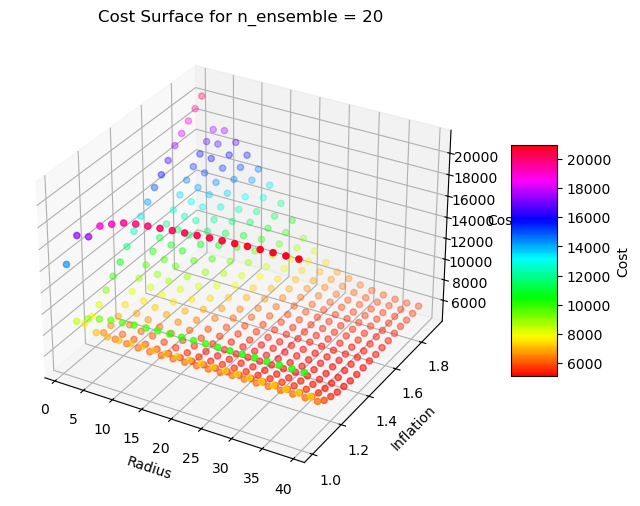

In [40]:
import pickle
with open('l96_ensemble_data.pkl', 'rb') as file:
    loaded_results = pickle.load(file)

n_ensemble, data = loaded_results[2]  
radius_values, inflation_values, cost_values = data[:, 0], data[:, 1], data[:, 2]
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot using extracted data
scat = ax.scatter(radius_values, inflation_values, cost_values, c=cost_values, cmap='hsv', marker='o')
ax.set_xlabel('Radius')
ax.set_ylabel('Inflation')
ax.set_zlabel('Cost')
ax.set_title(f'Cost Surface for n_ensemble = {n_ensemble}')

# Adding a color bar to interpret the cost values more easily
color_bar = fig.colorbar(scat, ax=ax, shrink=0.5, aspect=5)
color_bar.set_label('Cost')

plt.show()

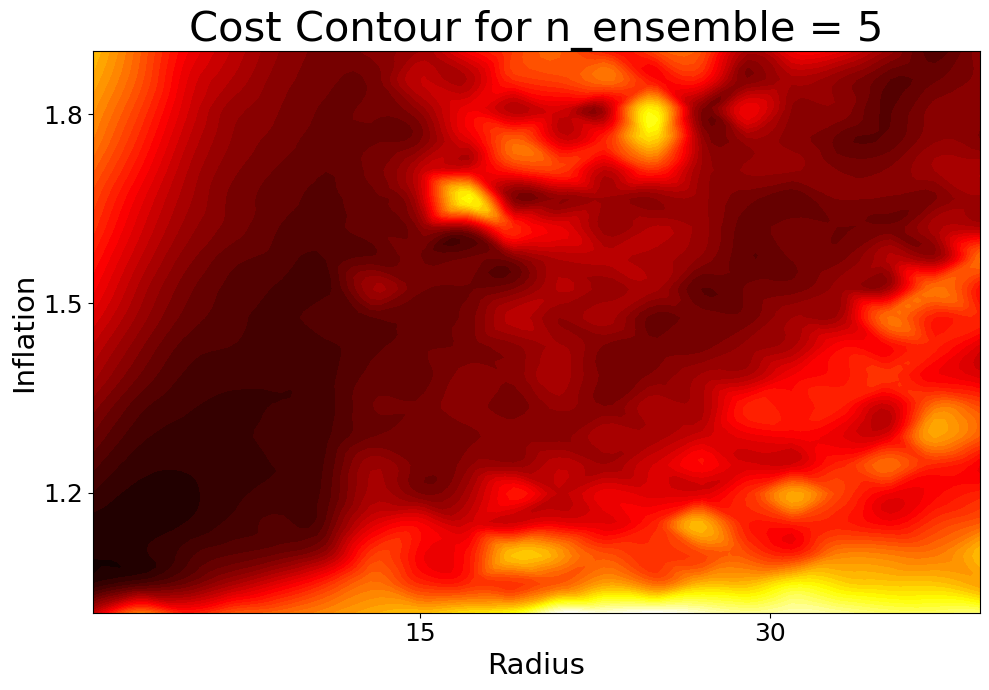

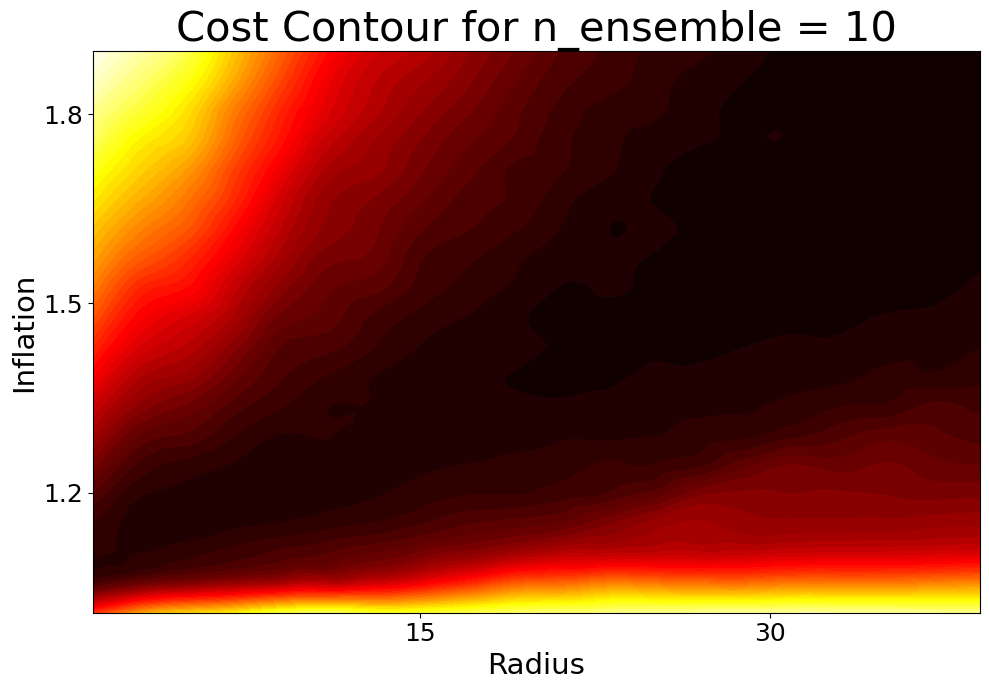

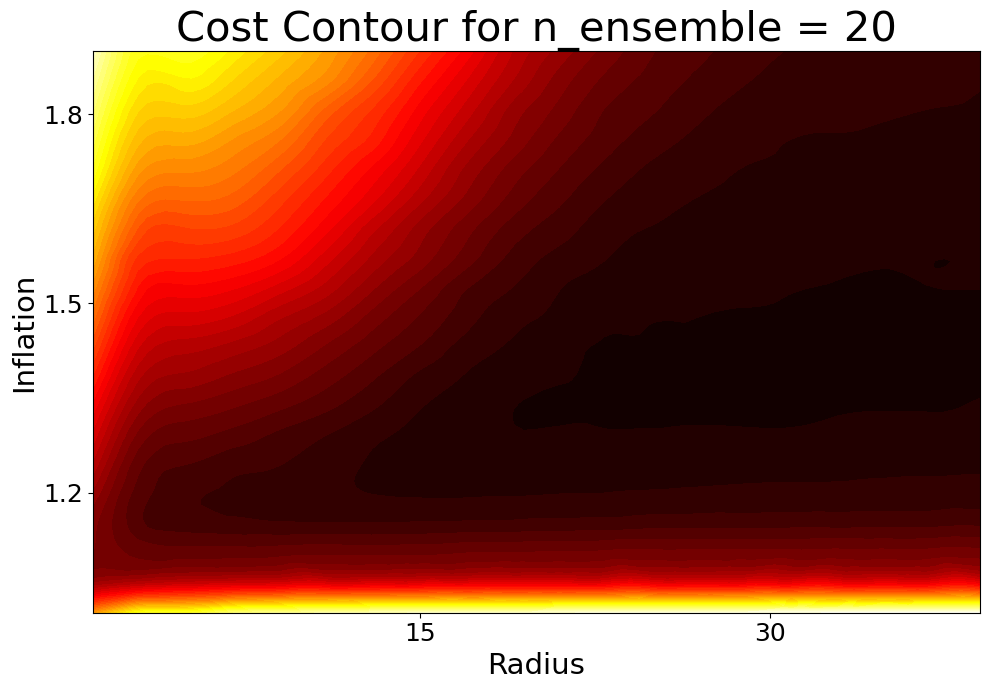

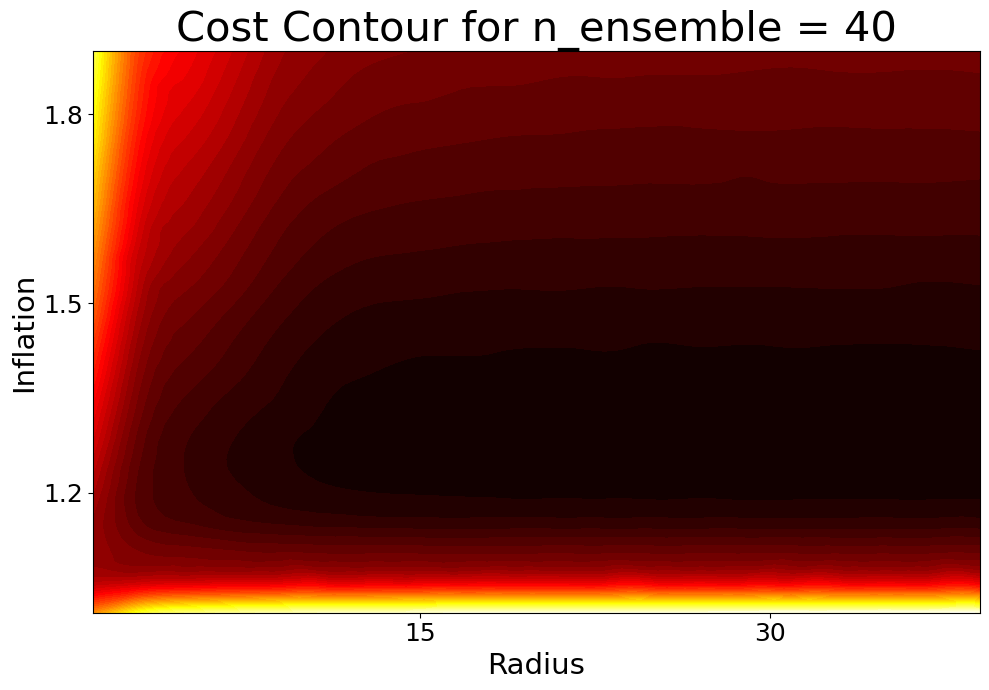

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import pickle

def plot_cost_contours(loaded_results, ensemble_sizes, scaling=1.0, max_n_locator=5):
    for idx, n_ensemble in enumerate(ensemble_sizes):
        data = loaded_results[idx][1]
        radius_values, inflation_values, cost_values = data[:, 0], data[:, 1], data[:, 2]

        grid_radius, grid_inflation = np.mgrid[min(radius_values):max(radius_values):100j, min(inflation_values):max(inflation_values):100j]

        grid_cost = griddata((radius_values, inflation_values), cost_values, (grid_radius, grid_inflation), method='cubic')

        plt.figure(figsize=(10, 7))
        cp = plt.contourf(grid_radius, grid_inflation, grid_cost, levels=50, cmap='hot')
        #cbar = plt.colorbar(cp)
        #cbar.set_label('Cost', fontsize=14*scaling)
        #cbar.ax.tick_params(labelsize=12*scaling)

        plt.xlabel('Radius', fontsize=14*scaling)
        plt.ylabel('Inflation', fontsize=14*scaling)
        plt.title(f'Cost Contour for n_ensemble = {n_ensemble}', fontsize=20*scaling)
        
        plt.xticks(fontsize=12*scaling)
        plt.yticks(fontsize=12*scaling)
        
        # reduce the number of x and y axis labels
        plt.gca().xaxis.set_major_locator(plt.MaxNLocator(max_n_locator))
        plt.gca().yaxis.set_major_locator(plt.MaxNLocator(max_n_locator))

        plt.tight_layout()
        plt.savefig(f'contour_plot_n_ensemble_{n_ensemble}.pdf')
        plt.show()
        plt.close()

# load data
with open('l96_ensemble_data.pkl', 'rb') as file:
    loaded_results = pickle.load(file)

# ensemble sizes
ensemble_sizes = [5, 10, 20, 40]

# plot with scaling and max_n_locator parameters
plot_cost_contours(loaded_results, ensemble_sizes, scaling=1.5, max_n_locator=3)
